In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import pandas as pd
from cartopy import crs as ccrs, feature as cfeature
import datetime
import glob
import os
import time

ERROR 1: PROJ: proj_create_from_database: Open of /usr/local/other/GEOSpyD/24.4.0-0_py3.12/2024-05-31/share/proj failed


## Functions

In [2]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [3]:
def normalize_rgb(colors):
    """Normalize a list of RGB colors from 0-255 to 0-1 range."""
    return [(r/255, g/255, b/255) for r, g, b in colors]

In [4]:
def create_color_dict(colors, positions, alpha=None):
    """
    Creates a dictionary for red, green, and blue channels, optionally adding alpha.

    Parameters:
        colors (list of tuples): List of RGB values in 0-255 range.
        positions (list): List of positions corresponding to the colors.
        alpha (list of tuples, optional): List of alpha channel values.

    Returns:
        dict: A dictionary with red, green, blue, and optionally alpha mappings.
    """
    normalized_colors = normalize_rgb(colors)
    cdict = {'red': [], 'green': [], 'blue': []}

    # Create red, green, and blue mappings
    for pos, (r, g, b) in zip(positions, normalized_colors):
        cdict['red'].append((pos, r, r))
        cdict['green'].append((pos, g, g))
        cdict['blue'].append((pos, b, b))

    # Add alpha channel if provided (only if alpha is not None)
    if alpha is not None:
        cdict['alpha'] = alpha

    return cdict

## Import NEE data

In [5]:
filepath = 'micasa-data/daily-0.1deg-final/holding/3hrly/2024/09/MiCASA_v1_flux_x3600_y1800_3hrly_202409*.nc4'
ds = xr.open_mfdataset(filepath, combine="by_coords", chunks={})['NEE']
ds

<xarray.DataArray 'NEE' (time: 240, lat: 1800, lon: 3600)> Size: 6GB
dask.array<concatenate, shape=(240, 1800, 3600), dtype=float32, chunksize=(1, 600, 1200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * lon      (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time     (time) datetime64[ns] 2kB 2024-09-01 ... 2024-09-30T21:00:00
Attributes:
    units:         kg m-2 s-1
    expressed_as:  carbon
    long_name:     Net ecosystem exchange

## Preprocess data for plotting

In [6]:
# Plot only North America, drop unused lat/lon
min_lon, max_lon = -170, -30
min_lat, max_lat = 10, 70
proj=ccrs.PlateCarree()

In [7]:
# Plot only two days for testing
time_start, time_stop = '2024-09-26', '2024-09-27'

In [8]:
ds_subset = ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon,max_lon), time=slice(time_start,time_stop))
ds_subset

<xarray.DataArray 'NEE' (time: 16, lat: 600, lon: 1400)> Size: 54MB
dask.array<getitem, shape=(16, 600, 1400), dtype=float32, chunksize=(1, 400, 1100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 5kB 10.05 10.15 10.25 10.35 ... 69.75 69.85 69.95
  * lon      (lon) float64 11kB -169.9 -169.8 -169.8 ... -30.25 -30.15 -30.05
  * time     (time) datetime64[ns] 128B 2024-09-26 ... 2024-09-27T21:00:00
Attributes:
    units:         kg m-2 s-1
    expressed_as:  carbon
    long_name:     Net ecosystem exchange

In [9]:
# mask zeroes
ds_subset_mask = ds_subset.where(ds_subset != 0)
ds_subset_mask

<xarray.DataArray 'NEE' (time: 16, lat: 600, lon: 1400)> Size: 54MB
dask.array<where, shape=(16, 600, 1400), dtype=float32, chunksize=(1, 400, 1100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 5kB 10.05 10.15 10.25 10.35 ... 69.75 69.85 69.95
  * lon      (lon) float64 11kB -169.9 -169.8 -169.8 ... -30.25 -30.15 -30.05
  * time     (time) datetime64[ns] 128B 2024-09-26 ... 2024-09-27T21:00:00
Attributes:
    units:         kg m-2 s-1
    expressed_as:  carbon
    long_name:     Net ecosystem exchange

In [10]:
# from PIL import Image
# import urllib.request
# image_url   = ' https://svs.gsfc.nasa.gov/cgi-bin/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&LAYERS=2915_21224&FORMAT=image/png&WIDTH=2048&HEIGHT=1024&CRS=CRS:84&BBOX=-180.0,-90.0,180.0,90.0&STYLES='
# with urllib.request.urlopen(image_url) as url:
#     img = Image.open(url)
#     img = np.array(img)  # Convert image to NumPy array
# mpl.image.imread('')

## Plot each time stamp as a static output

In [11]:
# Define output directory
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)
filename = 'micasa'

In [13]:
# Define the colormap colors/transparency
colors = [
    (109, 10, 245),
    (255, 255, 255),
    (245, 138, 0)
]
# Define the position of these colors
positions = [0, 0.5, 1]

# Define alpha
alpha = [(0.0, 1.0, 1.0), # Opaque at 0 
          (0.4, 0.8, 0.8), 
          (0.5, 0, 0), 
          (0.6,  0.8, 0.8), 
          (1.0, 1.0, 1.0)]  # Opaque at 1

In [14]:
# Make a custom colormap
cdict = create_color_dict(colors,positions,alpha)
custom_cmap = mcolors.LinearSegmentedColormap('custom_cmap', cdict)

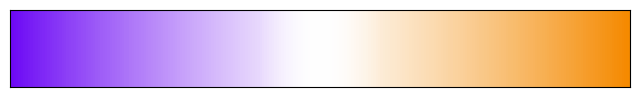

In [15]:
# Test the colormap
gradient = np.linspace(-1, 1, 256).reshape(1, -1)
fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=custom_cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [16]:
# import basemap from Joe's directory:
# map_path = '/discover/nobackup/jardizzo/maps/BlackMarble_2016/BlackMarble_2016_2048x1024.png'

Sep 26 2024 00:00Z <class 'str'>
2024092600Z <class 'str'>
frames/micasa_2024092600Z.png


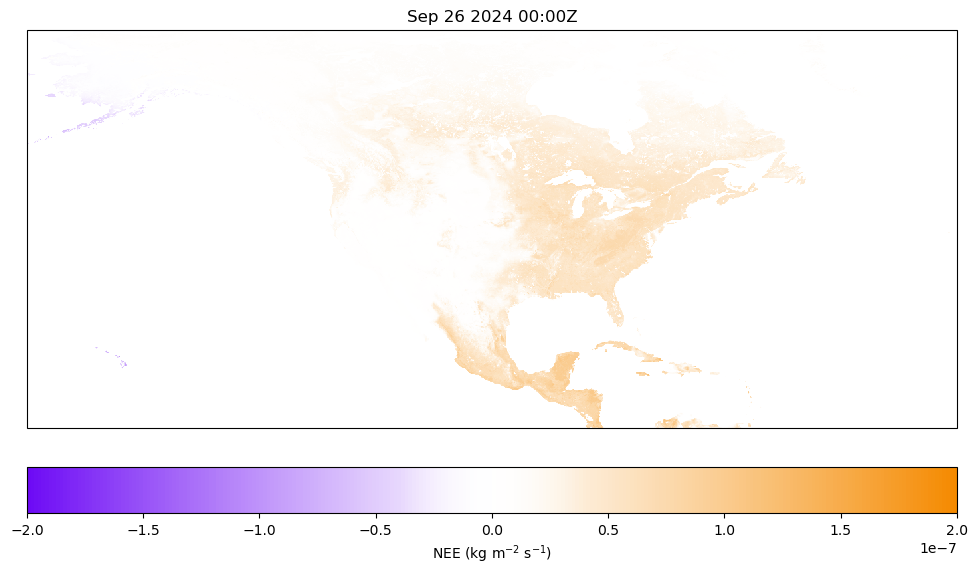

In [17]:
# Testing plot design for animation
fig, ax = plt.subplots(figsize=(12,10),subplot_kw= {'projection': proj});
# ax.stock_img() # default basemap

ax.set_extent([min_lon,max_lon,min_lat,max_lat], crs=proj)

data_at_time = ds_subset_mask.isel(time=0)

im = ax.pcolormesh(data_at_time.lon, data_at_time.lat, data_at_time.variable,
                       cmap=custom_cmap,vmin=-2e-7, vmax=2e-7)

time_value = data_at_time.time.dt
print(time_value)
title = time_value.strftime('%b %d %Y %H:%MZ').item()
print(title, type(title))

ax.set_title(title)

cbar = plt.colorbar(im, ax=ax, orientation='horizontal',pad=0.05)
cbar.set_label("NEE (kg m$^{-2}$ s$^{-1}$)")
filedt = time_value.strftime('%Y%m%d%HZ').item()
print(filedt,type(filedt))

frame = f"{output_dir}/{filename}_{filedt}.png"
print(frame)


In [ ]:
print(time_value.day)

if time_value.day == 1:
    print('Yes')


In [ ]:
# for i, t in enumerate(ds_subset_mask.time):
#     iter_start = time.time()
    
#     fig, ax = plt.subplots(figsize=(8, 6),subplot_kw= {'projection': proj})
#     # ax.stock_img() # default basemap
#     ax.set_extent([min_lon,max_lon,min_lat,max_lat], crs=proj)
    
#     # Subset data for the current time step
#     data_at_time = ds_subset_mask.isel(time=i)
    
#     # Create plot
#     im = ax.pcolormesh(data_at_time.lon, data_at_time.lat, data_at_time.variable,
#                        cmap=custom_cmap, vmin=-2e-7, vmax=2e-7)

#     time_value = pd.to_datetime(data_at_time.time.values)
#     title = time_value.strftime('%b %d %Y')
#     ax.set_title(title)

#     # Add colorbar
#     cbar = plt.colorbar(im, ax=ax, orientation='horizontal',pad=0.05)
#     cbar.set_label("NEE (kg m$^{-2}$ s$^{-1}$)")
#     # Save frame
#     filedt = time_value.strftime('%Y%m%d')
#     frame = f"{output_dir}/{filename}_{filedt}.png"
#     plt.savefig(frame, dpi=150)
#     plt.close(fig)  # Free memory
# print("Frame generation complete.")

In [ ]:
iter_start = time.time()
iter_end = time.time()
iter_elapsed = iter_end - iter_start
iter_minutes = int(iter_elapsed // 60)
iter_seconds = int(iter_elapsed % 60)
print(f"Iteration took {iter_minutes} min {iter_seconds} sec")